In [1]:
%matplotlib inline

import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import signal

# This one is only available in the development verison of statsmodels
# Run:
#    pip install git+https://github.com/statsmodels/statsmodels.git
# to install the development version.
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Always make it pretty.
plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklean below, this keeps them out of our hair.
import warnings
warnings.filterwarnings('ignore')

In [2]:
d = pd.read_csv('data/cleaned_data_together.csv')
def df_cleaner(df):
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    return df
df = df_cleaner(d)
df = df.set_index(pd.DatetimeIndex(df.DateTime))

In [3]:
dfm =df.resample('M').mean()

In [4]:
def plot_trend_data(ax, column_name, df):
    ax.plot(df.index, df[column_name])
    ax.set_title("Ten years trend of {}".format(column_name))

In [5]:
dfm.columns

Index(['Henry Hub Price $/MMBtu', 'Temp', 'Production MMCF', 'Storage BCFE',
       'Reserves BCFE', 'Consumption MMCF', 'DOY'],
      dtype='object')

In [6]:
dfm.head()

,Henry Hub Price $/MMBtu,Temp,Production MMCF,Storage BCFE,Reserves BCFE,Consumption MMCF,DOY
DateTime,,,,,,,
2010-01-31,5.813871,30.039787,2.192028e+06,2864.645161,255035.0,1.677131e+06,16.0
2010-02-28,5.302143,31.285932,2.146020e+06,2196.321429,255035.0,1.801731e+06,45.5
2010-03-31,4.270000,42.269455,2.196771e+06,1670.774194,255035.0,2.502120e+06,75.0
2010-04-30,3.991667,51.953373,2.210163e+06,1735.133333,255035.0,2.809788e+06,105.5
2010-05-31,4.135806,59.160539,2.067809e+06,2085.483871,255035.0,2.469750e+06,136.0


In [7]:
data_columns = ['Henry Hub Price $/MMBtu', 'Temp', 'Production MMCF', 'Storage BCFE',
       'Reserves BCFE', 'Consumption MMCF', 'DOY']

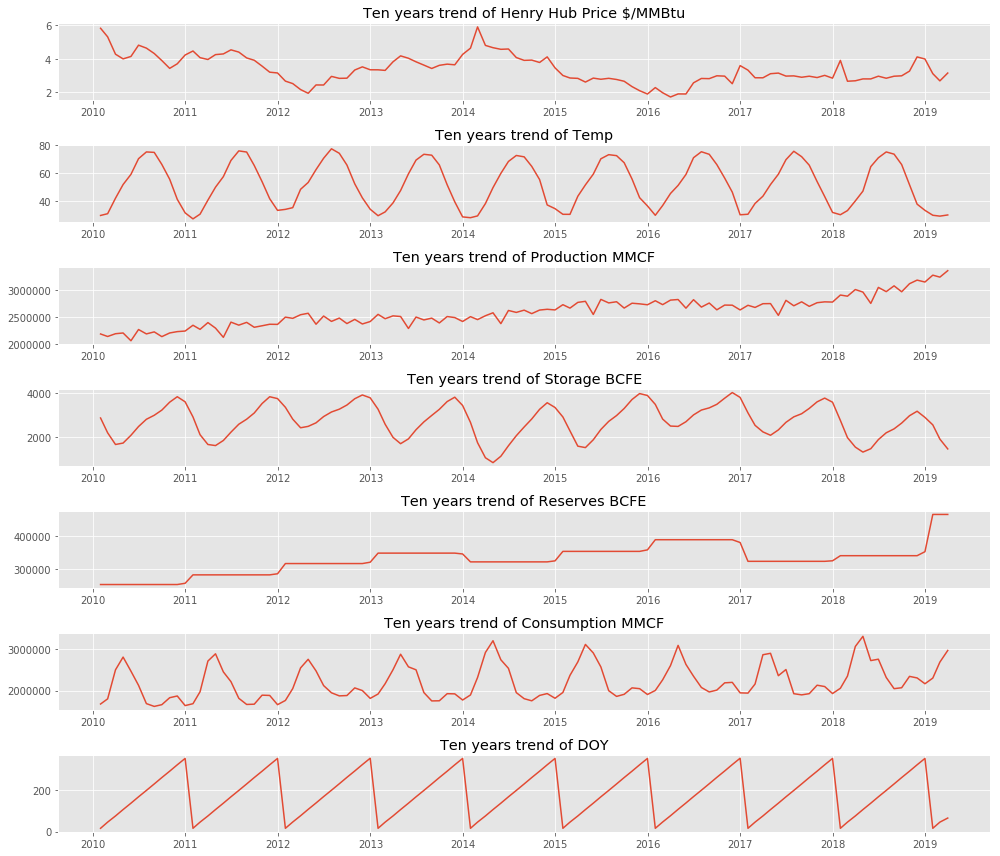

In [8]:
fig, axs = plt.subplots(len(data_columns), figsize=(14, 12))

for ax, column_name in zip(axs, data_columns):
    plot_trend_data(ax, column_name, dfm)
    
plt.tight_layout()

#### Some observations:

- the `price` plot shows a more random pattern than the others. it has a non-linear trend over time with some seasonal behaviour.
- The `temperature` plot shows very strong oscillations aligned with seasonality in the northern hemisphere. 
- The `production` plot shows a general increase over time, probably influenced by the increase in shale plays production efficiencies.
- The `storage` plot shows very strong oscillations aligned with seasonality in the northern hemisphere. In general, storage levels decrease during the winter and increase during the summer.
- The `reserves` plot shows a general increase over time, probably influenced by the increase in shale plays discoveries in the last few years.
- The `consumption` plot shows very strong oscillations aligned with seasonality in the northern hemisphere. In general, natural gas consumption levels increase during the winter and decrease during the summer.

In [9]:
def plot_trend_data(ax, name, series):
    ax.plot(series.index, series)
    ax.set_title(" Trend For {}".format(name))

def fit_moving_average_trend(series, window=365):
    return series.rolling(window, center=True).mean()

def plot_moving_average_trend(ax, name, series, window=12):
    moving_average_trend = fit_moving_average_trend(series, window)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, moving_average_trend)

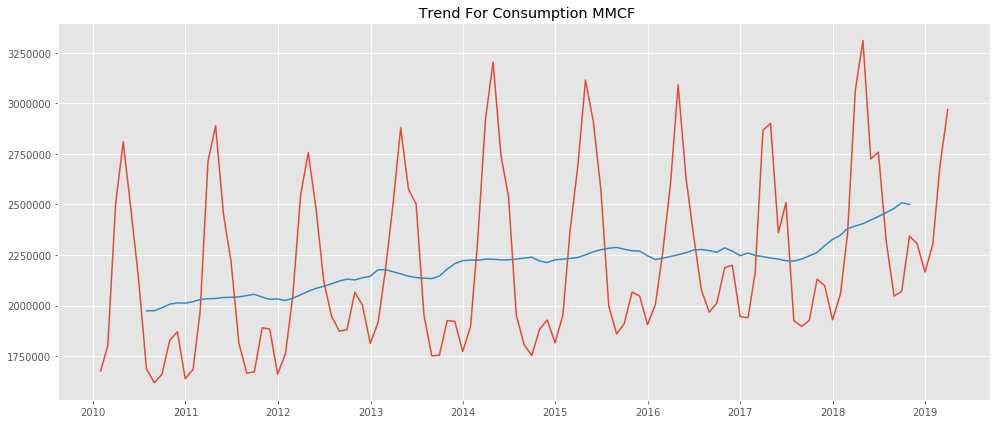

In [10]:
fig, axs = plt.subplots(figsize=(14, 6))
plot_moving_average_trend(axs, 'Consumption MMCF', dfm['Consumption MMCF'])
plt.tight_layout()


## Trend-Seasonal-Residual Decomposition

The Classical Trend-Seasonal-Residual Decomposition expresses a time series as the sum of three components:

$$ y_t = T_t + S_t + R_t $$


In [11]:
def plot_seasonal_decomposition(axs, series, sd):
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series")
    axs[1].plot(series.index, sd.trend)
    axs[1].set_title("Trend Component $T_t$")
    axs[2].plot(series.index, sd.seasonal)
    axs[2].set_title("Seasonal Component $S_t$")
    axs[3].plot(series.index, sd.resid)
    axs[3].set_title("Residual Component $R_t$")

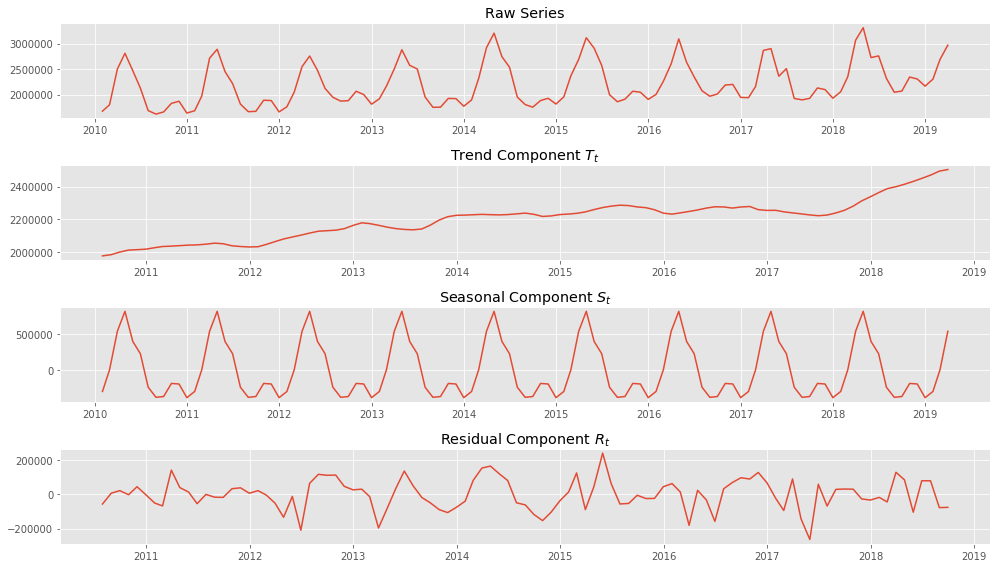

In [12]:
consumption_decomposition = sm.tsa.seasonal_decompose(dfm['Consumption MMCF'], freq= 12)

fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, dfm['Consumption MMCF'], consumption_decomposition)
plt.tight_layout()

### Sharp increase in queries around wintertime, dropoff for queries around spring and fall, and slide increase for queries around summer.

# Stationary Analysis

In [14]:
def plot_series_and_difference(axs, series, title):
    diff = series.diff()
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(series.index, diff)
    axs[1].set_title("Series of First Differences: {}".format(title))

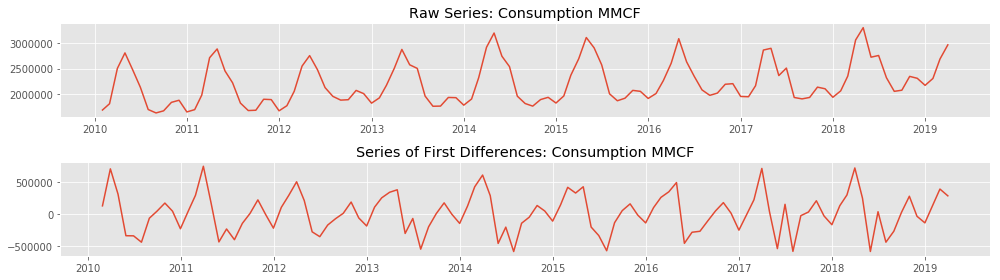

In [15]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, dfm['Consumption MMCF'], 'Consumption MMCF')
fig.tight_layout()

In [16]:
test = sm.tsa.stattools.adfuller(dfm['Consumption MMCF'])
print("ADF p-value for python series: {0:2.2f}".format(test[1]))

ADF p-value for python series: 0.91


In [17]:
Consumption_differences =dfm['Consumption MMCF'].diff()[1:]
test = sm.tsa.stattools.adfuller(Consumption_differences)
print("ADF p-value for differenced python series: {0:2.2f}".format(test[1]))

ADF p-value for differenced python series: 0.00


In [18]:
def series_and_lagged(series, lag=1):
    truncated = np.copy(series)[lag:]
    lagged = np.copy(series)[:(len(truncated))]
    return truncated, lagged

def compute_autocorrelation(series, lag=1):
    series, lagged = series_and_lagged(series, lag=lag)
    return np.corrcoef(series, lagged)[0, 1]

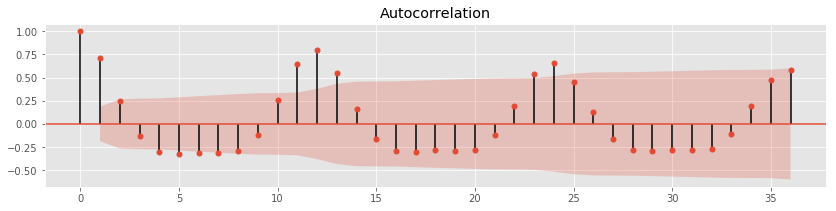

In [19]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(dfm['Consumption MMCF'], lags=3*12, ax=ax)
#ax.set_ylim([-.1, .1])

- There is a very striking spike at exactly 12 lags, which is the number of weeks in a year. This is repeated, less significantly, at a lag of twice 12.

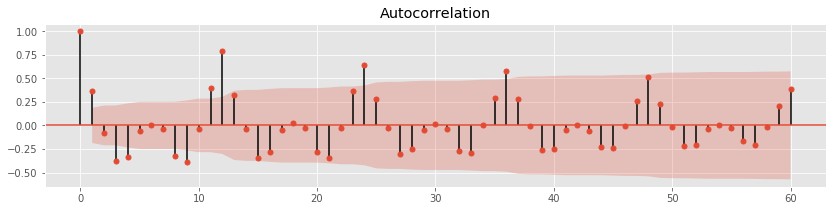

In [20]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(Consumption_differences, lags=5*12, ax=ax)
#ax.set_ylim([-.1, .1])

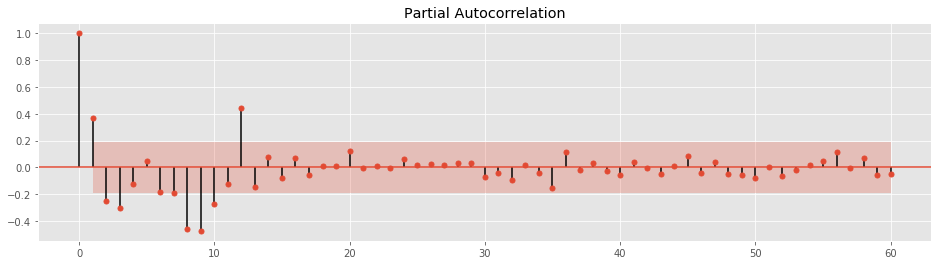

In [21]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_pacf(Consumption_differences, lags=5*12, ax=ax, method='ywmle')

The parameters of the ARIMA model are defined as follows:

p: The number of lag observations included in the model, also called the lag order. 3

d: The number of times that the raw observations are differenced, also called the degree of differencing. 1

q: The size of the moving average window, also called the order of moving average. 1

sp: 1

sd: 0 

sq: 3

For the ARIMA model there is AR (significant lookback from the partial auto),I (The number of differences used to make the data stationary), and MA (significant lookback from the auto). In this case, it will be 2,1,2 respectively. However, it will be also interesting to use a (2,1,4), a (8,1,2), a (4,1,4), a (4,1,6), and a (8,1,6).

In [35]:
X = dfm['Consumption MMCF']
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
model = SARIMAX(train, order=(3, 1, 1), seasonal_order=(1, 0, 1, 12)).fit()

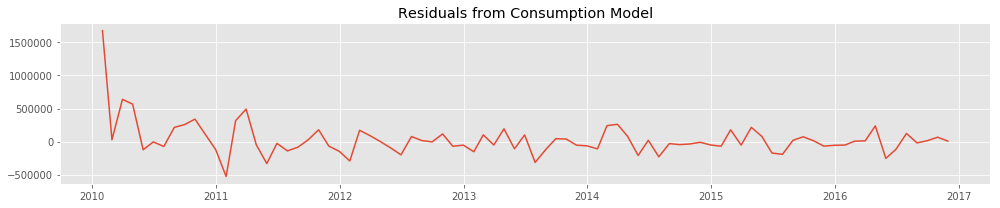

In [36]:
fig, ax = plt.subplots(1, figsize=(14, 3))
ax.plot(model.resid.index, model.resid)
ax.set_title("Residuals from Consumption Model")
plt.tight_layout()

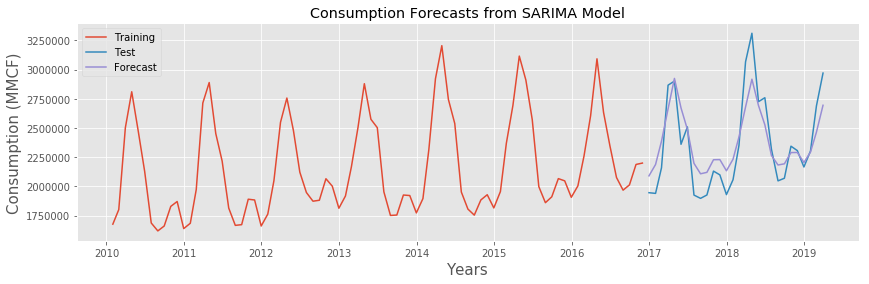

In [37]:
fig, ax = plt.subplots(1, figsize=(14, 4))
ax.plot(train.index, train, label= 'Training')
ax.plot(test, label= 'Test')
preds = model.predict('2016-12-31', '2019-03-31', dynamic=True, ax=ax, plot_insample=False)

ax.plot(preds.index, preds, label= 'Forecast')

_ = ax.legend().get_texts()[1].set_text("95% Prediction Interval")
#_ = ax.legend(loc="lower left")

_ = ax.set_title("Consumption Forecasts from SARIMA Model")
#ax.set_xlim([0, 40])
#ax.set_ylim([2.4, 3.5])
ax.set_ylabel("Consumption (MMCF)", fontsize = 15)
ax.set_xlabel("Years", fontsize = 15)
ax.legend()

In [31]:
error = mean_squared_error(test, preds)
print('Test MSE: %.5f' % error)

Test MSE: 37786564767.43679


In [32]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = SARIMAX(history, order=(1, 1, 1), seasonal_order=(1, 0, 1, 12))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
#     print('{} of {} predicted={}, expected={}'.format(t, len(test), yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.5f' % error)

# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

Test MSE: 33660259060.69633


### ~11% improvement, but this is mostly using the previous sample to update the prediction. (one sample lag)

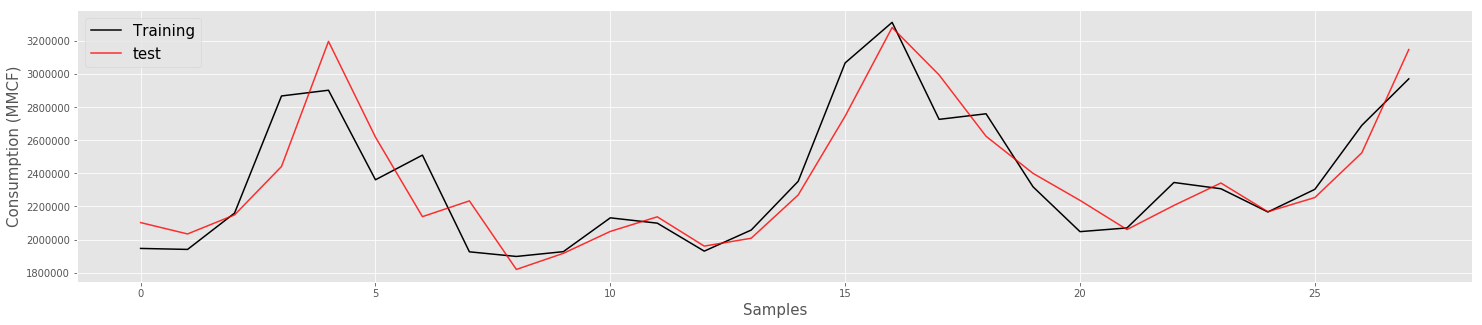

In [40]:
fig, axs = plt.subplots(figsize=(25, 5))
#axs.plot(np.array(train), label= 'Training')
axs.plot(np.array(test), color='black', label= 'Training')
axs.plot(predictions, color='red', alpha = 0.8, label= 'test')
axs.set_ylabel("Consumption (MMCF)", fontsize = 15)
axs.set_xlabel("Samples", fontsize = 15)
axs.legend(fontsize = 15)
#axs.set_xlim([0, 100])
#axs.set_ylim([2.5, 3.5])
plt.show()